In [125]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim
import scipy.stats as stats
from tqdm import tqdm
from scipy.sparse.linalg import eigsh

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Set parameters

In [126]:
n = 1500 # sample size
c = 0.1 # p/n
alpha = 0.1 # L/n
beta = alpha/c

p = int(c*n) # dimension
L = int(alpha*n) # band size
setting = "$n = {} \quad p = {} \quad L = {}$".format(n, p, L)

mu_norms = np.linspace(1, 2, 10)
max_nvecs = 9
alpha_ = 1/np.sqrt(n)

k = 2 # number of classes
pi = np.array([0.5, 0.5]) # proportion of each class
# centroid of each class
mu = stats.norm.rvs(size=(p, 1))
mu /= np.linalg.norm(mu)
M0 = np.concatenate([+mu, -mu], axis=1)

J = utils.getJ(n, pi)

# Computations

In [127]:
psi = utils.nu(L, 2*np.arange(n)*np.pi/n)
aton = np.argsort(psi) # Ascending order -> natural order
ntoa = np.argsort(aton) # Natural order -> ascending order

psi_k, psi_l = np.meshgrid(psi, psi)
E = np.isclose(psi_k, psi_l)

n_est = 6
est = np.empty((n_est, len(mu_norms), max_nvecs, n))
est[:] = np.nan

In [128]:
for ite, mu_norm in enumerate(tqdm(mu_norms)):
    M = mu_norm*M0

    spikes = (mu_norm**2+1)*psi*(1/p+np.mean(psi_l/((mu_norm**2+1)*psi_k-psi_l), axis=0))
    zeta = (1-p*np.mean((psi_l/((mu_norm**2+1)*psi_k-psi_l))**2, axis=0))*((mu_norm**2)/(mu_norm**2+1))

    # Get indices of spikes grouped by multiplicity
    visible_idx = []
    visible = (zeta > 0)
    visible_where = np.where(visible)[0]
    for i in visible_where:
        if i != -1:
            group = list(np.where(E[i])[0])
            visible_idx.append(group)
            for j in group:
                visible_where[visible_where == j] = -1

    visible_idx_flat = [ntoa[x] for group in visible_idx for x in group] # in ascending order

    basis_t = utils.basis(n, L, kind='toeplitz')
    basis_c = utils.basis(n, L, kind='circulant')
    
    # Simulations
    eigvals_t, eigvecs_t = utils.simul(1, L, M, J, mask='toeplitz', comp=False, verbose=False)
    eigvals_c, eigvecs_c = utils.simul(1, L, M, J, mask='circulant', comp=False, verbose=False)
    
    idx = visible_idx_flat[:max_nvecs]
    tot_nvecs = len(idx)
    flip = np.sign(np.sum(J[:, 0]*eigvecs_t[0, idx]*basis_t[idx], axis=1))
    coeff_zeta = np.sqrt(zeta[aton[idx]])/(1-zeta[aton[idx]])
    est[0, ite, :tot_nvecs] = np.cumsum(flip*(basis_t[idx]*eigvecs_t[0, idx]).T*coeff_zeta, axis=1).T
    est[1, ite, :tot_nvecs] = np.cumsum(flip*(eigvecs_t[0, idx]/basis_t[idx]).T*coeff_zeta, axis=1).T
    est[2, ite, :tot_nvecs] = np.cumsum(flip*((basis_t[idx]*eigvecs_t[0, idx])/(alpha_**2+basis_t[idx]**2)
                                             ).T*coeff_zeta, axis=1).T
    for i, nvecs in enumerate(range(1, tot_nvecs+1)):
        Pi = (eigvecs_t[0, idx[:nvecs]].T)@eigvecs_t[0, idx[:nvecs]]
        Pi_perp = np.eye(n)-Pi
        kurtosis = n*np.sum(basis_t[idx[:nvecs]]**4)/np.sum(basis_t[idx[:nvecs]]**2)**2
        gamma = 2*kurtosis*zeta[aton[idx[:nvecs]]]*(2-zeta[aton[idx[:nvecs]]])*((1-zeta[aton[idx[:nvecs]]])**2)/n
        UWU = ((basis_t[idx[:nvecs]].T)*(1/gamma))@basis_t[idx[:nvecs]]
        UDWU = ((basis_t[idx[:nvecs]].T)*zeta[aton[idx[:nvecs]]]*(1/gamma))@basis_t[idx[:nvecs]]
        est[3, ite, i] = eigsh(Pi_perp*UWU, k=1, which='SA')[1][:, 0]
        est[4, ite, i] = eigsh(np.eye(n)*UDWU-Pi*UWU, k=1, which='SA')[1][:, 0]
        def func(d):
            delta = np.sum((eigvecs_t[0, idx[:nvecs]]@((basis_t[idx[:nvecs]]*d).T))**2,
                           axis=0)-zeta[aton[idx[:nvecs]]]
            return np.sum(delta**2)
        def jac(d):
            delta = np.sum((eigvecs_t[0, idx[:nvecs]]@((basis_t[idx[:nvecs]]*d).T))**2,
                           axis=0)-zeta[aton[idx[:nvecs]]]
            return 4*(Pi*(((basis_t[idx[:nvecs]].T)*delta)@basis_t[idx[:nvecs]]))@d
        def hess(d):
            mat1 = np.zeros((n, n))
            for i in idx[:nvecs]:
                vec = (Pi*(basis_t[i][:, None]@basis_t[i][None, :]))@d
                mat1 += vec[:, None]@vec[None, :]
            return 8*mat1-4*Pi*(((basis_t[idx[:nvecs]].T)*zeta[aton[idx[:nvecs]]])@basis_t[idx[:nvecs]])
        const = optim.NonlinearConstraint(lambda d: d@d, 1, 1, jac=lambda d: 2*d)
        res = optim.minimize(func, np.ones(n), method='trust-constr', jac=jac, hess=hess, constraints=const)
        est[5, ite, i] = res.x

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [29:01<00:00, 174.17s/it]


In [129]:
GT = np.tile(J[:, 0]-J[:, 1], n_est*len(mu_norms)*max_nvecs).reshape(est.shape)
cerr = np.mean(np.sign(est) != GT, axis=-1)
cerr[[3, 4, 5]] = np.minimum(cerr[[3, 4, 5]], 1-cerr[[3, 4, 5]])
cerr[np.isnan(est[..., 0])] = np.nan

# Visualisation

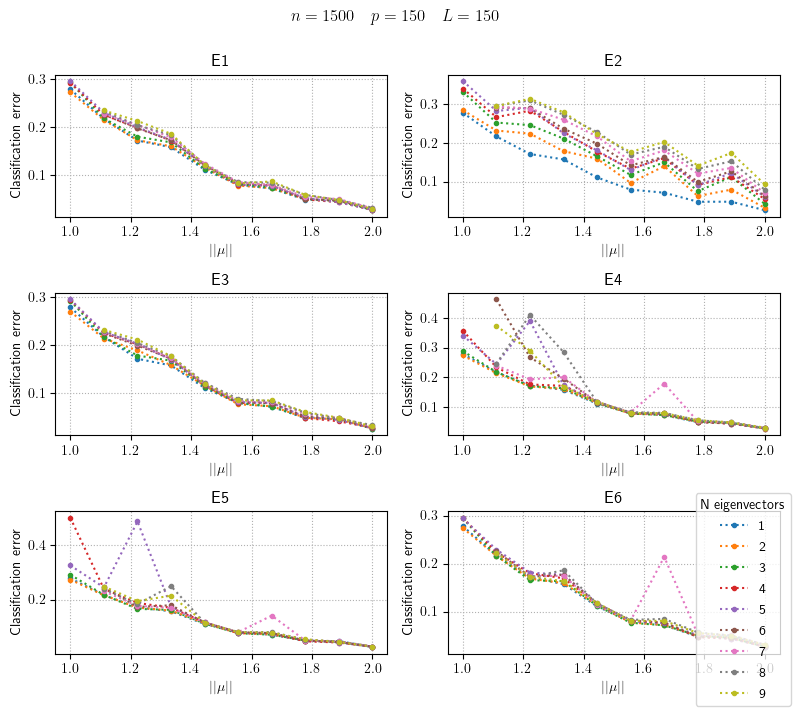

In [130]:
nvecs_r = range(1, max_nvecs+1)

fig, ax = plt.subplots(3, 2, figsize=(8, 7))
ax = ax.ravel()
for i in range(n_est):
    ax[i].plot(mu_norms, cerr[i], ls=':', marker='.')
    ax[i].grid(ls=':')
    ax[i].set_xlabel("$|| \mu ||$")
    ax[i].set_ylabel("Classification error")
    ax[i].set_title("E{}".format(i+1))
fig.legend(nvecs_r, title="N eigenvectors", loc='lower right')
fig.suptitle(setting, y=1)
fig.tight_layout()
plt.show()

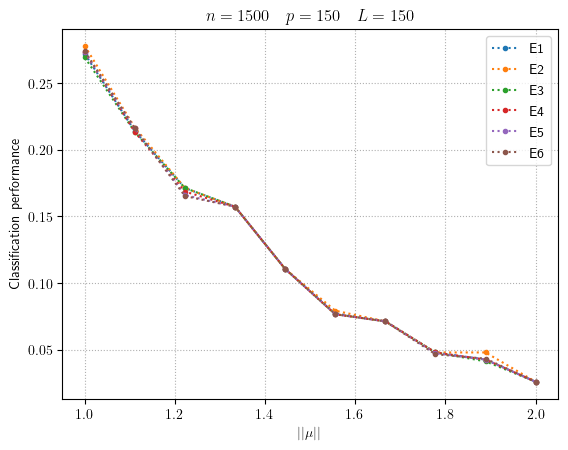

In [131]:
plt.plot(mu_norms, np.nanmin(cerr, axis=-1).T, marker='.', ls=':')
plt.grid(ls=':')
plt.xlabel("$|| \mu ||$")
plt.ylabel("Classification performance")
plt.title(setting)
plt.legend(["E{}".format(i) for i in range(1, n_est+1)])
plt.show()

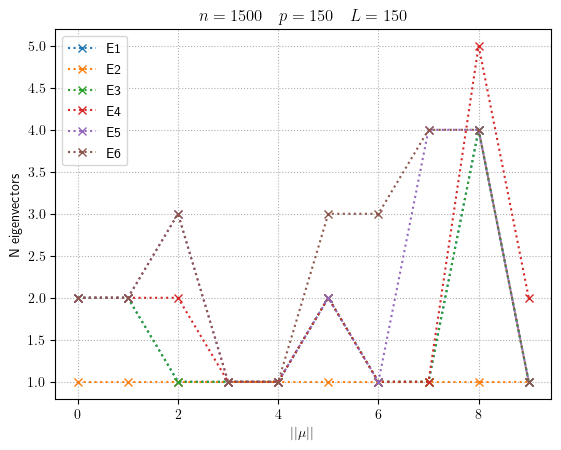

In [132]:
plt.plot(np.nanargmin(cerr, axis=-1).T+1, marker='x', ls=':')
plt.grid(ls=':')
plt.xlabel("$|| \mu ||$")
plt.ylabel("N eigenvectors")
plt.title(setting)
plt.legend(["E{}".format(i) for i in range(1, n_est+1)])
plt.show()